In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
from sklearn.model_selection import train_test_split
y = train.SalePrice
X = train.drop(['SalePrice', 'PoolQC', 'MiscFeature', 'Fence', 'Alley', 'FireplaceQu'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

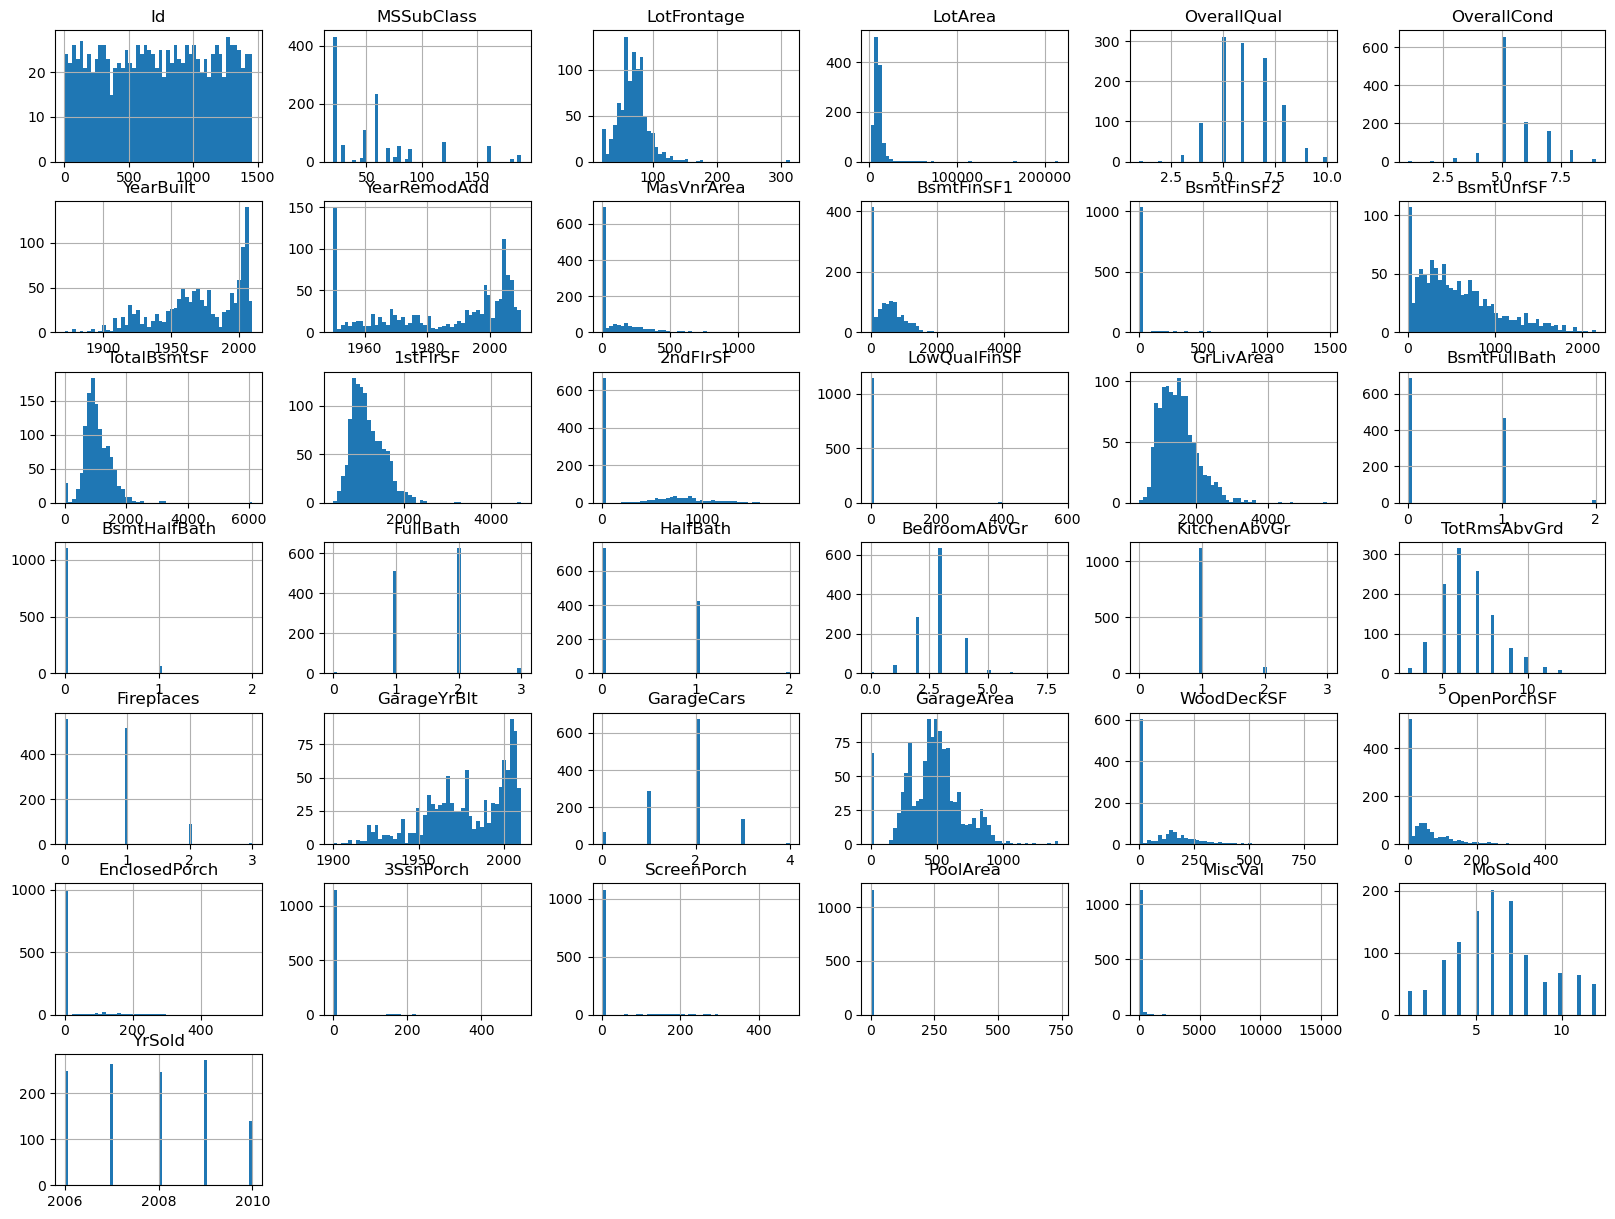

In [6]:
import matplotlib.pyplot as plt
X_train.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
categorical_cols = X_train.select_dtypes(include="object").columns
numerical_cols = X_train.select_dtypes(exclude="object").columns

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [9]:
numerical_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                  ('std_scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

In [11]:
train_prepared = preprocessor.fit_transform(X_train)
val_prepared = preprocessor.transform(X_valid)
test_prepared = preprocessor.transform(test)

In [12]:
from sklearn.metrics import mean_absolute_error 
model.fit(train_prepared, y_train)
preds = model.predict(val_prepared)

score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 17538.2227739726


In [13]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation', scores.std())

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
scores = cross_val_score(model, train_prepared, y_train, scoring='neg_mean_squared_error', cv=3)
model_scores = np.sqrt(-scores)

In [16]:
display_scores(model_scores)

Scores: [31179.20872067 29931.94873056 38921.61204155]
Mean: 33344.256497592236
Standard Deviation 3976.5215552042987


In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
param_grid = [{'n_estimators': [50,100, 150,200,250], 'max_depth': [2,4,6,8,10,12], 'min_samples_split':[2,4,6],
               'max_features':['sqrt', 'log2', 'None'],
              'bootstrap': [True, False]}]
randomized_search = RandomizedSearchCV(model,param_grid, cv=5,
                                      scoring='neg_mean_squared_error', 
                                      return_train_score=True)
randomized_search.fit(train_prepared,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [2, 4, 6, 8, 10, 12],
                                         'max_features': ['sqrt', 'log2',
                                                          'None'],
                                         'min_samples_split': [2, 4, 6],
                                         'n_estimators': [50, 100, 150, 200,
                                                          250]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [19]:
randomized_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

In [20]:
model = RandomForestRegressor(n_estimators= 50, min_samples_split=2, max_features='sqrt',
                              max_depth=8, bootstrap=False)

In [21]:
model.fit(train_prepared, y_train)
preds = model.predict(val_prepared)

score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 19226.693641983755


In [22]:
final_model = randomized_search.best_estimator_

In [23]:
final_predictions = final_model.predict(test_prepared)

In [24]:
submission_df = pd.DataFrame({'Id': test['Id'], 'SalePrice': final_predictions})
submission_df.to_csv('submission.csv', index=False)